This notebook provides an example of how to use the `poopy` package to access historical CSO discharge monitoring data provided by water companies.

First, we import the libraries we need.

In [1]:
# To help demonstrate the package
import datetime
import os

import matplotlib.pyplot as plt

from poopy.companies import ThamesWater

First we initiate an instance of a `WaterCompany` object. We opt to use the `ThamesWater` as an example. 

In [ ]:
tw_client_id = os.getenv("TW_CLIENT_ID")
tw_client_secret = os.getenv("TW_CLIENT_SECRET")

if tw_client_id is None or tw_client_secret is None:
    raise ValueError(
        "Thames Water API keys are missing from the environment!\n Please set them and try again."
    )

tw = ThamesWater(tw_client_id, tw_client_secret)

Initialising Thames Water object...
Requesting current status data from Thames Water API...
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeCurrentStatus?limit=1000&offset=0
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeCurrentStatus?limit=1000&offset=1000
	No more records to fetch


Initiating a `WaterCompany` object will automatically download the current status of all the monitors. What we want to do is explore historical information for past discharges. This can either be done at the level of the individual `Monitor` or at the level of the `WaterCompany`. Lets explore the former first using the "Bourton-On-The-Water" monitor.

In [3]:
monitor = tw.active_monitors["Bourton-On-The-Water"]
monitor.get_history(verbose=True)

Requesting historical data for Bourton-On-The-Water from Thames Water API...
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeAlerts?limit=1000&offset=0&col_1=LocationName&operand_1=eq&value_1=Bourton-On-The-Water
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeAlerts?limit=1000&offset=1000&col_1=LocationName&operand_1=eq&value_1=Bourton-On-The-Water
	No more records to fetch
	Printing full API response...
             LocationName PermitNumber LocationGridRef       X       Y  \
0    Bourton-On-The-Water    CTCR.2036      SP17621907  417620  219070   
1    Bourton-On-The-Water    CTCR.2036      SP17621907  417620  219070   
2    Bourton-On-The-Water    CTCR.2036      SP17621907  417620  219070   
3    Bourton-On-The-Water    CTCR.2036      SP17621907  417620  219070   
4    Bourton-On-The-Water    CTCR.2036      SP17621907  417620  219070   
5    Bourton-On-The-Water    CTCR.2036      SP17621907  417620  219070   

/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Bourton-On-The-Water contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-12-14T09:30:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Bourton-On-The-Water contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-12-08T13:45:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Bourton-On-The-Water contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-12-08T13:45:00. Skipping that entry...
  warnings.warn(


Above, we ran the `get_history()` method that extracts the historical data for a given monitor. This information is stored in the `Monitor` object in the `history` attribute. This is a List of `Event` objects. For example, lets see what the fifth event in the history is. Recall that an `Event` object can either be a `Discharge`, `Offline` or `NoDischarge`. 

In [4]:
fifth_event = monitor.history[4]
fifth_event.print()


        
        --------------------------------------
        Event Type: Discharging
        Site Name: Bourton-On-The-Water
        Permit Number: CTCR.2036
        OSGB Coordinates: (417620, 219070)
        Receiving Watercourse: Groundwater
        Start Time: 2024-10-02 06:15:00
        End Time: 2024-10-02 22:15:00
        Duration: 960.0 minutes
        


To visualise the history once it has been calculated we can use the `plot_history()` method. This will plot the history of the monitor as a 'barcode', the colour of the bar corresponds to the status of the event through time. Brown is a discharge, grey is offline and white is no discharge. Note that the barchart automatically goes back as far as the first recorded discharge or offline event for that monitor. 

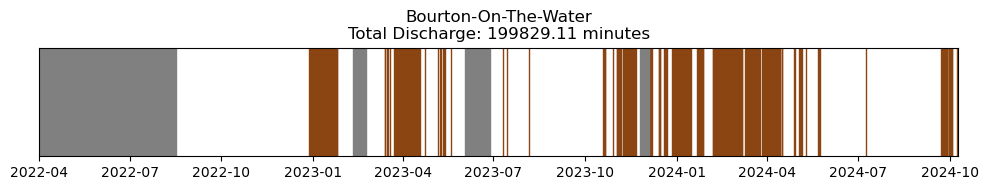

In [5]:
monitor.plot_history()

We can make it plot for a shorter period by passing a `since` parameter. For example, lets look at only the last 3 months.

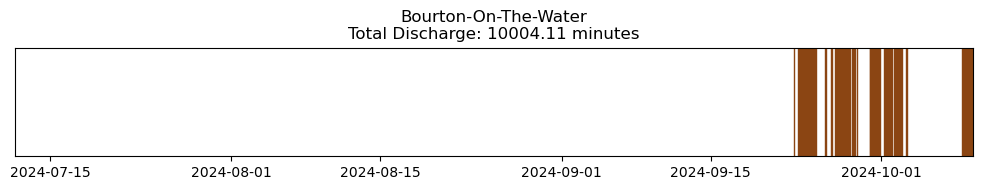

In [6]:
since_3_months = datetime.datetime.now() - datetime.timedelta(days=90) # 90 days = 3 months
monitor.plot_history(since=since_3_months)

We can print out some summary information about the total amount of discharge as follows:

In [7]:
print(f"Total discharge: {monitor.total_discharge()} minutes")
print(f"Total discharge last 12 months: {monitor.total_discharge_last_12_months()} minutes")
print(f"Total discharge last 6 months: {monitor.total_discharge_last_6_months()} minutes")
print(f"Total discharge since start of year: {monitor.total_discharge_since_start_of_year()} minutes")
print(f"Total discharge last 3 months: {monitor.total_discharge(since=since_3_months)} minutes")

Total discharge: 199829.11359808332 minutes
Total discharge last 12 months: 133634.11361166666 minutes
Total discharge last 6 months: 19860.00000005 minutes
Total discharge since start of year: 110324.11362461667 minutes
Total discharge last 3 months: 10004.113631483333 minutes


If we want to calculate the history for all monitors managed by a particular water company we can do this by calling the `set_all_histories()` method on the `WaterCompany` object. This sets the `history` attribute of all the monitors in the `WaterCompany` object.

In [8]:
tw.set_all_histories()

Requesting historical data for all monitors from Thames Water API...
	Requesting historical events since 2022-04-01 00:30:00...
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeAlerts?limit=1000&offset=0
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeAlerts?limit=1000&offset=1000
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeAlerts?limit=1000&offset=2000
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeAlerts?limit=1000&offset=3000
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeAlerts?limit=1000&offset=4000
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeAlerts?limit=1000&offset=5000
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeAlerts?limit=1000&offset=6000
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/S

/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Amersham Balancing Tanks/Amersham Vale STK contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2024-08-23T16:00:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Amersham Balancing Tanks/Amersham Vale STK contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2024-08-12T16:30:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Amersham Balancing Tanks/Amersham Vale STK contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2024-08-12T16:30:00. Skipping that entry...
  warnings.warn(


	Building history for Arborfield...
	Building history for Arford...
	Building history for Ascot...
	Building history for Ash Ridge (Wokingham)...
	Building history for Ash Vale...
	Building history for Aston Le Walls...
	Building history for Auckland Road Storm Tanks...
	Building history for Avon Dassett...
	Building history for Avondale Rd...
	Building history for Aylesbury...
	Building history for Bakers Farm, High Wych...
	Building history for Bampton...
	Building history for Banbury...
	Building history for Banbury Rd Middleton Cheney...
	Building history for Bancroft Rugby Ground, Buckhurst Hill...
	Building history for Barbers Lane...
	Building history for Barkway...
	Building history for Basingstoke...
	Building history for Beckley...
	Building history for Beckton...
	Building history for Beddington...
	Building history for Beech Hall Crescent, Walthamstow...
	Building history for Beenham...
	Building history for Beer Lane...
	Building history for Bell Wharf...
	Building history

/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Bourton-On-The-Water contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-12-14T09:30:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Bourton-On-The-Water contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-12-08T13:45:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Bourton-On-The-Water contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-12-08T13:45:00. Skipping that entry...
  warnings.warn(


	Building history for Box Hill...
	Building history for Boyne Avenue, Hendon...
	Building history for Bracknell...
	Building history for Bramley...
	Building history for Brent Cross Flyover...
	Building history for Brent Valley Golf Course, LB Ealing...
	Building history for Brentfield Gardens...
	Building history for Brickendon...
	Building history for Bridle Close, Ewell...
	Building history for Brixton Storm Relief Sewer...


/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Brixton Storm Relief Sewer contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2024-02-08T14:32:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Brixton Storm Relief Sewer contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2024-01-11T09:22:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Brixton Storm Relief Sewer contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2024-01-11T09:22:00. Skipping that entry...
  warnings.warn(


	Building history for Broadwell...
	Building history for Brockham Bridge...
	Building history for Brook Way, Chigwell...
	Building history for Broome (Attenuation Tank)...
	Building history for Bucklebury (Briff Lane)...
	Building history for Bucknell...
	Building history for Buntingford...
	Building history for Burford...
	Building history for Burghfield...
	Building history for Burstow...
	Building history for Bushey Court, Raynes Park...
	Building history for Bute Street CSO...
	Building history for Byfield...
	Building history for Caddington...
	Building history for Cage End, Essex...
	Building history for Camberley...
	Building history for Canfield End, Little Canfield...
	Building history for Canfold Wood...
	Building history for Canterbury Road, Thornton Heath...
	Building history for Capel...


/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Canterbury Road, Thornton Heath contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2024-06-28T07:15:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Canterbury Road, Thornton Heath contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2024-06-24T07:15:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Canterbury Road, Thornton Heath contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2024-06-24T07:15:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for

	Building history for Carlton Cres Jnc Blenheim Cres...
	Building history for Carterton...
	Building history for Cascade Road Storm Tanks, Buckhurst...
	Building history for Cassington...
	Building history for Castle Drive...
	Building history for Castle Gardens, Dorking...
	Building history for Chacombe...
	Building history for Chadlington...
	Building history for Chalgrove...
	Building history for Channelsea West Ham Lane PS ...
	Building history for Chapel Row (Berks)...
	Building history for Chapmore End...
	Building history for Charlbury...
	Building history for Charlton Storm Relief...
	Building history for Charlton-On-Otmoor...
	Building history for Charlwood, Surrey...
	Building history for Chelsea, London, Sw10...
	Building history for Chertsey...
	Building history for Chesham...


/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Chertsey contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2024-03-15T23:45:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Chertsey contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2024-03-12T08:00:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Chertsey contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2024-03-12T08:00:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Chertsey contains an invalid entry! 
Reason: an offline Stop

	Building history for Chieveley...
	Building history for Chigwell Road / Langston Road...
	Building history for Chigwell Road, Woodford Green...
	Building history for Chingford Storm Tanks...
	Building history for Chinnor...


/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Chinnor contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2024-08-02T08:30:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Chinnor contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2024-07-31T15:15:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Chinnor contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2024-07-31T15:15:00. Skipping that entry...
  warnings.warn(


	Building history for Chipping Norton...
	Building history for Chipping Warden...
	Building history for Chisledon Storm Tanks ...
	Building history for Chobham...
	Building history for Cholsey...
	Building history for Church Hanborough...
	Building history for Church Hill Road, Barnet...
	Building history for Church Road...
	Building history for Church Road/Brent Lodge Park (Bunny Park)...
	Building history for Church Street KT13 8DP...
	Building history for Church Street Sewer...
	Building history for Churt...
	Building history for Cirencester...
	Building history for Clanfield...
	Building history for Clapham Storm Relief Sewer, London...
	Building history for Clifton...
	Building history for Cobham Bridge, Adj Cobham PS...
	Building history for Codicote...
	Building history for Colgate...
	Building history for Colin Crescent, Colindale...
	Building history for Combe...
	Building history for Commonside...
	Building history for Compton (Berks)...
	Building history for Conolly Road Han

/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Cottered contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2024-03-17T23:45:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Cottered contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2024-03-13T22:30:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Cottered contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2024-03-13T22:30:00. Skipping that entry...
  warnings.warn(


	Building history for Counters Creek, Lots Road...
	Building history for Cranleigh...
	Building history for Crawley...
	Building history for Cricklade...
	Building history for Cricklewood Broadway...
	Building history for Cricklewood Lane, Cricklewood (A41 Hendon Way)...
	Building history for Crofton Road, Sunnydale...
	Building history for Crondall...
	Building history for Crooked Billet...
	Building history for Cropredy...
	Building history for Crossness...
	Building history for Cuddington...
	Building history for Culham...
	Building history for Culworth...
	Building history for Dagnall...
	Building history for Daintry Close...
	Building history for Dallow Road Jnc Lyndhurst Road...
	Building history for Darkes Lane, Potters Bar...
	Building history for Dartford Creek Storm...
	Building history for Dartnell Park, Byfleet...
	Building history for Deadmans Bridge...
	Building history for Dean Oak Lane...
	Building history for Deephams...
	Building history for Deptford Creek Storm...


/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Dartford Creek Storm contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-10-15T23:45:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Dartford Creek Storm contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2022-12-06T03:00:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Dartford Creek Storm contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2022-12-06T03:00:00. Skipping that entry...
  warnings.warn(


	Building history for Deptford Storm Relief...
	Building history for Didcot...
	Building history for District Road...
	Building history for Dorchester...
	Building history for Dorking...


/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Dorchester contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2024-01-09T10:45:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Dorchester contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2024-01-02T02:00:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Dorchester contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2024-01-02T02:00:00. Skipping that entry...
  warnings.warn(


	Building history for Dorking Road...
	Building history for Dorton...
	Building history for Draycot Foliat...
	Building history for Drayton (Oxon)...
	Building history for Dunstable Road - Beech Road...
	Building history for Dunstable Road - Beech Road CSO 2...
	Building history for Dunstable Road - Francis Street...
	Building history for Duntshill Road...
	Building history for Earl...
	Building history for Earlswood (Reigate)...
	Building history for Earlswood Common, S Of Pendleton Road...
	Building history for East Garston...
	Building history for East Grafton...


/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor East Garston contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2024-03-05T15:45:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor East Garston contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-04-19T08:00:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor East Garston contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-04-19T08:00:00. Skipping that entry...
  warnings.warn(


	Building history for East Lane CSO 1...
	Building history for East Shefford...
	Building history for Eastcote Avenue...
	Building history for Easthampstead Park...
	Building history for Edgware Road...
	Building history for Elmcroft Avenue, Wanstead...
	Building history for Elms Road CSO...
	Building history for Elvetham Close...
	Building history for Empress Avenue ...
	Building history for Epping...
	Building history for Epsom Storm Tanks, Longmead Road...
	Building history for Esher...
	Building history for Essendon, Holywell Bridge...
	Building history for Ewhurst Road, Cranleigh, Surrey...
	Building history for Eydon...
	Building history for Fairfield Avenue 1...
	Building history for Fairford...
	Building history for Falcon Brook...
	Building history for Falloden Court & Brookland Rise...
	Building history for Faringdon...
	Building history for Faringdon House CSO...


/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Faringdon House CSO contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2024-06-14T15:06:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Faringdon House CSO contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2024-06-10T13:14:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Faringdon House CSO contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2024-06-10T13:14:00. Skipping that entry...
  warnings.warn(


	Building history for Farnborough (Warks)...
	Building history for Farnham...
	Building history for Fergusson Road, Banbury...
	Building history for Field End Rd Storm (Harrow)...
	Building history for Field End Road (East)...
	Building history for Finstock...
	Building history for Fleet...
	Building history for Fleet Main Line Sewer...
	Building history for Folkestone Rd Tanks, East Ham...
	Building history for Forest Hill...
	Building history for Francis Road Spill...
	Building history for Friday Street, Henley...
	Building history for Frogmore Storm Relief (Bell Lane Creek) CSO...
	Building history for Frogmore Storm Relief (River Wandle) CSO...
	Building history for Fulmer Drive CSO (Howards Wood Drive)...
	Building history for Fyfield (Wilts)...
	Building history for Gap Road (Cemetery)...
	Building history for Garden Way...
	Building history for Gascoigne Rd Storm Tanks, Beckton...
	Building history for George Street - King Street...
	Building history for George Street - Wellingt

/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Gerrards Cross contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-08-14T10:15:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Gerrards Cross contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-08-10T14:00:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Gerrards Cross contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-08-10T14:00:00. Skipping that entry...
  warnings.warn(


	Building history for Godalming...
	Building history for Gordon Road...
	Building history for Gordon Road (u205)...
	Building history for Goring...
	Building history for Goswell Street...
	Building history for Granville Road...
	Building history for Great Bedwyn...
	Building history for Greatworth...
	Building history for Greenwich...
	Building history for Grendon Underwood...
	Building history for Guildford...
	Building history for Gun Wharf (Wapping Dock)...
	Building history for Haddenham...
	Building history for Hadham Mill...
	Building history for Hambleden...
	Building history for Hammersmith...


/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Hammersmith contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2024-09-02T13:30:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Hammersmith contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2024-09-02T07:15:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Hammersmith contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2024-09-02T07:15:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Hammersmith contains an invalid entry! 
Reason: an 

	Building history for Hampstead Norreys...
	Building history for Hamstead Marshall...
	Building history for Hanger Lane...
	Building history for Hannington...
	Building history for Hanwell...
	Building history for Harpenden...
	Building history for Hartley Wintney...
	Building history for Haslemere...
	Building history for Haslemere STW CSO...
	Building history for Hatfield Heath...
	Building history for Hattchets Cricklade...
	Building history for Heath Wall PS...
	Building history for Henley...
	Building history for Henley Road...
	Building history for Heyford...
	Building history for High Road Loughton...
	Building history for High Road, Woodford...
	Building history for High Wycombe...
	Building history for Highfield Road Jct With Brookside Road...
	Building history for Highworth...
	Building history for Highworth Eastrop...
	Building history for Hillside Avenue...
	Building history for Hockford (Pirbright)...
	Building history for Hogsmill...
	Building history for Holloway Storm S

/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Knights Lane contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-04-06T10:00:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Knights Lane contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2022-12-21T05:15:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Knights Lane contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2022-12-21T05:15:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Leatherhead contains an invalid entry! 
Reason: 

	Building history for Lechlade...
	Building history for Leopold Road, Church Path...
	Building history for Leverson Street...
	Building history for Lightwater...
	Building history for Lincoln Road CSO...
	Building history for Lindsay Drive, Falcon Way...
	Building history for Little Compton...
	Building history for Little Hallingbury...
	Building history for Little Marlow...
	Building history for Little Milton...
	Building history for Littlemead Ind Estate, Cranleigh...


/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Little Milton contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2024-01-12T15:45:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Little Milton contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-12-19T11:15:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Little Milton contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-12-19T11:15:00. Skipping that entry...
  warnings.warn(


	Building history for Littlemore Low Level...
	Building history for London Bridge...
	Building history for London Road Near Hatherop Lane...
	Building history for London Road, Marlborough...
	Building history for Long Crendon...
	Building history for Long Reach...
	Building history for Longbridge Road...


/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor London Bridge contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-10-09T13:42:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor London Bridge contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2022-11-28T17:52:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor London Bridge contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2022-11-28T17:52:00. Skipping that entry...
  warnings.warn(


	Building history for Longley Road (1), Tooting High Street...
	Building history for Longstone Ave, Drayton Road...
	Building history for Low Hall Farm Storm Tanks, Walthamstow...
	Building history for Low Level 1 N, Grosvenor Ditch, Millb...
	Building history for Lower Cherwell St, Banbury...
	Building history for Ludgershall...
	Building history for Luton...
	Building history for Lyon Park Avenue...
	Building history for Lytton Road SSO...
	Building history for Maidenhead...
	Building history for Main Road, Sidcup...
	Building history for Manor Drive Stormwater Tanks...
	Building history for Manor Farm...
	Building history for Maple Lodge...
	Building history for Mapleton Road...
	Building history for Markenfield Road, Guildford...
	Building history for Markyate...


/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Manor Drive Stormwater Tanks contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2024-01-26T09:15:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Manor Drive Stormwater Tanks contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2024-01-19T10:00:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Manor Drive Stormwater Tanks contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2024-01-19T10:00:00. Skipping that entry...
  warnings.warn(


	Building history for Marlborough...
	Building history for Marsh Gibbon...
	Building history for Marsh Lane Bridge, Taplow...
	Building history for Marston St Lawrence SPS...
	Building history for Marsworth...
	Building history for Mays Lane Overflow ...
	Building history for Melford Road, London, E11...
	Building history for Merstham...
	Building history for Middle Barton...
	Building history for Middleton Cheney...


/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Middleton Cheney contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-11-14T10:00:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Middleton Cheney contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-10-28T06:45:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Middleton Cheney contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-10-28T06:45:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Middleton Cheney contains an invalid

	Building history for Middleton Stoney...
	Building history for Midgham...
	Building history for Mill Green (Hatfield)...
	Building history for Millbank, Crawley...
	Building history for Milton-Under-Wychwood...
	Building history for Mogden...
	Building history for Montrose Avenue/Blenheim Crescent...
	Building history for Moreton Pinkney...
	Building history for Moreton-In-Marsh...
	Building history for Moreton-In-Marsh (Primrose Court)...
	Building history for Mornington Crescent...
	Building history for Mortimer (Stratfield)...
	Building history for Mulberry Court, Hall Road...
	Building history for Nags Head Lane (Brentwood)...
	Building history for Ne Storm Relief Shadwell, King Edward Mem Park...
	Building history for Near Sezincote Lodge...


/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Ne Storm Relief Shadwell, King Edward Mem Park contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-12-04T12:38:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Ne Storm Relief Shadwell, King Edward Mem Park contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-12-01T09:32:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Ne Storm Relief Shadwell, King Edward Mem Park contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-12-01T09:32:00. Skipping that entry...
  warnings.warn(


	Building history for Neasden Station...
	Building history for Netherlands Road CSO...
	Building history for New Bedford Road, Luton...
	Building history for New Mill (Eversley Lower Common)...
	Building history for Newbury...
	Building history for Newmans Lane...
	Building history for Nightingale Lane...


/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Nightingale Lane contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-03-30T14:20:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Nightingale Lane contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2022-11-28T15:36:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Nightingale Lane contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2022-11-28T15:36:00. Skipping that entry...
  warnings.warn(


	Building history for Norfolk Street...
	Building history for North End Road CSO...
	Building history for North Weald...
	Building history for North West Storm Relief...
	Building history for Northleach...
	Building history for Northumberland Street...


/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Northumberland Street contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-07-07T12:36:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Northumberland Street contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-06-29T05:00:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Northumberland Street contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-06-29T05:00:00. Skipping that entry...
  warnings.warn(


	Building history for Nutter Lane / Preston Drive, Wanstead...
	Building history for Oak Hill Park CSO...
	Building history for Oakentrough...
	Building history for Oakley Road...
	Building history for Ockham Road South Foul Sewer Overflow...
	Building history for Ockley Road...
	Building history for Old Palace Lane ...
	Building history for Opposite St Stephens Hall...
	Building history for Outside 115 Wentworth Road...
	Building history for Outside 135 Leeside Crescent (Formerly Brookside Road, Golders Green)...
	Building history for Oxford...
	Building history for Pangbourne...
	Building history for Park Street - Bailey Street...
	Building history for Park Street - Opp Parmead (lower level weir)...
	Building history for Park Town South & West, Luton...
	Building history for Passfield...
	Building history for Pauls Pier...
	Building history for Pavilion in Roxbourne Park...
	Building history for Pease Pottage...
	Building history for Penwith Road...
	Building history for Peterborough

/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Shutford contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-01-12T08:15:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Shutford contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-01-11T17:00:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Shutford contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-01-11T17:00:00. Skipping that entry...
  warnings.warn(


	Building history for Silchester...
	Building history for Sloane Street, Raneleigh Gardens...
	Building history for Slough...
	Building history for Smith Street...
	Building history for Somerset Road, Wimbledon...
	Building history for Sonning Common...
	Building history for South Close, Barnet...
	Building history for South Ealing Road, W5...


/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Smith Street contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-09-01T10:40:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Smith Street contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-08-05T14:00:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Smith Street contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-08-05T14:00:00. Skipping that entry...
  warnings.warn(


	Building history for South Lane, Ash...
	Building history for South Leigh...
	Building history for South Moreton...
	Building history for South Norwood...
	Building history for South Park, Ilford...
	Building history for Spooks Hill, North Holmwood...
	Building history for SSO, Junction Crane Valley/Bathroadse...
	Building history for St Andrews Road, Black Horse Lane...
	Building history for St Jamess Road...
	Building history for St Pauls Avenue CSO...
	Building history for Stag Lane CSO...
	Building history for Stamford Brook...
	Building history for Standlake...
	Building history for Standon...
	Building history for Stanford-In-The-Vale...
	Building history for Stansted Airport...
	Building history for Stansted Mountfitchet...
	Building history for Stanton Fitzwarren STW...
	Building history for Stanton Harcourt...


/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Stanton Fitzwarren STW contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-10-15T20:56:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Stanton Fitzwarren STW contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-10-13T16:00:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Stanton Fitzwarren STW contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-10-13T16:00:00. Skipping that entry...
  warnings.warn(


	Building history for Stewkley...
	Building history for Stoke Road, Cobham...
	Building history for Stone...
	Building history for Stonebridge Brook...
	Building history for Stonebridge SSO, Brockham...
	Building history for Streatham & Balham Storm Relief...
	Building history for Streatham Storm Relief...


/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Stonebridge SSO, Brockham contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2022-10-27T10:30:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Stonebridge SSO, Brockham contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2022-10-23T10:30:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Stonebridge SSO, Brockham contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2022-10-23T10:30:00. Skipping that entry...
  warnings.warn(


	Building history for Streatham Vale Storm Relief...
	Building history for Sudbury Heights Ave, Allendale Road...
	Building history for Sunnyside Road...
	Building history for SW Storm Relief Sewer, London...
	Building history for Swains Road...
	Building history for Swindon (Rodbourne)...
	Building history for Tackley...
	Building history for Takeley...
	Building history for Takeley - Garnetts...
	Building history for Taylors Crescent, Cranleigh...
	Building history for Temple Place Essex Street...
	Building history for Tetsworth...
	Building history for Thame...
	Building history for The Broadway (Ray Park 2)...
	Building history for The Willows, North Hinksey Lane...
	Building history for Therfield...
	Building history for Theydon Bois...
	Building history for Thornwood...
	Building history for Thrale Road...
	Building history for Tideway CSO...
	Building history for Tonstall Road...
	Building history for Tree Tops, Norbury...
	Building history for Tring...
	Building history for Tru

/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Willingale contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-04-12T08:00:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Willingale contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-04-11T21:00:00. Skipping that entry...
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1068: UserWarning: ! WARNING ! Alert stream for monitor Willingale contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-04-11T21:00:00. Skipping that entry...
  warnings.warn(


	Building history for Wimbledon Hill Road...
	Building history for Wimbledon Hill Wimbledon...
	Building history for Windsor...
	Building history for Wingrave...
	Building history for Winterbourne...
	Building history for Witney...
	Building history for Woking...
	Building history for Wood Street...
	Building history for Woodford Halse...
	Building history for Woodstock...
	Building history for Woodstock Road Oxford...
	Building history for Worcester Crescent...
	Building history for Worminghall...
	Building history for Worple Road, SW19...
	Building history for Wynters Brook, Hastingwood...


Then, the monitor's history object can be accessed as before. For example, lets get the history for the "Marlborough" monitor.

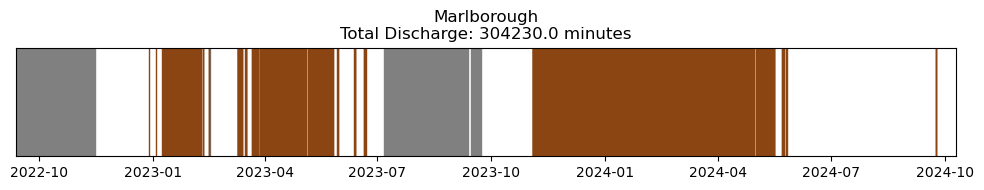

In [9]:
monitor = tw.active_monitors["Marlborough"]
monitor.plot_history()

We can query what event was occurring at a particular time as follows: 

In [10]:
time = datetime.datetime(2024, 1, 1)
event = monitor.event_at(time)
event.print()


        
        --------------------------------------
        Event Type: Discharging
        Site Name: Marlborough
        Permit Number: TEMP.2763
        OSGB Coordinates: (420120, 169200)
        Receiving Watercourse: River Kennet
        Start Time: 2023-12-31 15:45:00
        End Time: 2024-01-01 00:45:00
        Duration: 540.0 minutes
        


Alternatively, we can get all of the discharge events in the form of a `pandas` dataframe using the `get_history_df()` method. This returns a dataframe that contains all the discharge events for all the monitors managed by the water company, sorted from newest to oldest start times. This dataframe can then be analysed using standard pandas methods. The head of this dataframe is shown below:

In [11]:
df = tw.history_to_discharge_df()
print(df.head())

Building output data-table
	Processing (Northern) Low Level No 1 Brook Green
	Processing 15 Coldharbour Lane, Bushey
	Processing Abbess Roding
	Processing Abbey Mills
	Processing Abbeydale Road
	Processing Abingdon


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Abingdon' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1293: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, event._to_row()], ignore_index=True)
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Aldermaston' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Amersham Balancing Tanks/Amersham Vale STK' (in ThamesWater) is ongoing. `end_tim

	Processing Acton & Storm Works
	Processing Aldermaston
	Processing Aldershot Town
	Processing Alicia Avenue CSO
	Processing Allendale Road
	Processing Amersham Balancing Tanks/Amersham Vale STK
	Processing Ampney St Peter
	Processing Amyand Park Road, Twickenham
	Processing Andoversford


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Andoversford' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Appleton
	Processing Arborfield
	Processing Arford
	Processing Ascot
	Processing Ash Ridge (Wokingham)
	Processing Ash Vale
	Processing Aston Le Walls
	Processing Auckland Road Storm Tanks
	Processing Avon Dassett
	Processing Avondale Rd
	Processing Aylesbury
	Processing Bakers Farm, High Wych
	Processing Bampton


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Aylesbury' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Banbury
	Processing Banbury Rd Middleton Cheney
	Processing Bancroft Rugby Ground, Buckhurst Hill


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Banbury' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Barbers Lane
	Processing Barkway
	Processing Basingstoke
	Processing Beckley
	Processing Beckton
	Processing Beddington
	Processing Beech Hall Crescent, Walthamstow
	Processing Beenham


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Beenham' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Beer Lane
	Processing Bell Wharf
	Processing Benson
	Processing Bentley
	Processing Bentsbrook Road
	Processing Berkhamsted
	Processing Bicester
	Processing Birchanger - Duck End
	Processing Biscot Road CSO
	Processing Bishop Stortford Main
	Processing Blacknest, Sunningdale


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Bicester' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Bledington
	Processing Bletchingdon
	Processing Blind Mans Gate, Highclere


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Bledington' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Bletchingdon' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Bloxham
	Processing Blunsdon
	Processing Boddington
	Processing Bookham SPS
	Processing Bordon
	Processing Bourton-On-The-Water


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Bloxham' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Boddington' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Bourton-On-The-Water' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Box Hill
	Processing Boyne Avenue, Hendon
	Processing Bracknell
	Processing Bramley
	Processing Brent Cross Flyover
	Processing Brent Valley Golf Course, LB Ealing
	Processing Brentfield Gardens
	Processing Brickendon
	Processing Bridle Close, Ewell
	Processing Brixton Storm Relief Sewer


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Brickendon' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Broadwell
	Processing Brockham Bridge
	Processing Brook Way, Chigwell
	Processing Broome (Attenuation Tank)
	Processing Bucklebury (Briff Lane)


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Broadwell' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Bucklebury (Briff Lane)' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Bucknell
	Processing Buntingford
	Processing Burford
	Processing Burghfield
	Processing Burstow


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Burghfield' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Burstow' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Bushey Court, Raynes Park
	Processing Bute Street CSO
	Processing Byfield
	Processing Caddington
	Processing Cage End, Essex
	Processing Camberley
	Processing Canfield End, Little Canfield
	Processing Canfold Wood
	Processing Canterbury Road, Thornton Heath
	Processing Capel
	Processing Carlton Cres Jnc Blenheim Cres
	Processing Carterton
	Processing Cascade Road Storm Tanks, Buckhurst
	Processing Cassington
	Processing Castle Drive
	Processing Castle Gardens, Dorking
	Processing Chacombe
	Processing Chadlington


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Carterton' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Chadlington' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Chalgrove
	Processing Channelsea West Ham Lane PS 
	Processing Chapel Row (Berks)
	Processing Chapmore End
	Processing Charlbury
	Processing Charlton Storm Relief
	Processing Charlton-On-Otmoor


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Chapel Row (Berks)' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Charlton-On-Otmoor' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Charlwood, Surrey
	Processing Chelsea, London, Sw10
	Processing Chertsey
	Processing Chesham
	Processing Chieveley
	Processing Chigwell Road / Langston Road
	Processing Chigwell Road, Woodford Green
	Processing Chingford Storm Tanks
	Processing Chinnor


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Chinnor' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Chipping Norton
	Processing Chipping Warden
	Processing Chisledon Storm Tanks 
	Processing Chobham


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Chipping Norton' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Cholsey
	Processing Church Hanborough


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Church Hanborough' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Church Hill Road, Barnet
	Processing Church Road
	Processing Church Road/Brent Lodge Park (Bunny Park)
	Processing Church Street KT13 8DP
	Processing Church Street Sewer
	Processing Churt
	Processing Cirencester
	Processing Clanfield


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Cirencester' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Clanfield' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Clapham Storm Relief Sewer, London
	Processing Clifton
	Processing Cobham Bridge, Adj Cobham PS
	Processing Codicote
	Processing Colgate


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Codicote' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Combe' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Colin Crescent, Colindale
	Processing Combe
	Processing Commonside
	Processing Compton (Berks)
	Processing Conolly Road Hanwell
	Processing Coppice Green, Bracknell
	Processing Corbett Rd / Redbridge Lane, Wanstead
	Processing Cottered


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Cottered' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Cranleigh' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Counters Creek, Lots Road
	Processing Cranleigh
	Processing Crawley
	Processing Cricklade


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Cricklade' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Cricklewood Broadway
	Processing Cricklewood Lane, Cricklewood (A41 Hendon Way)
	Processing Crofton Road, Sunnydale
	Processing Crondall
	Processing Crooked Billet
	Processing Cropredy


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Cropredy' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Crossness
	Processing Cuddington
	Processing Culham
	Processing Culworth
	Processing Dagnall
	Processing Daintry Close
	Processing Dallow Road Jnc Lyndhurst Road
	Processing Darkes Lane, Potters Bar
	Processing Dartford Creek Storm
	Processing Dartnell Park, Byfleet
	Processing Deadmans Bridge
	Processing Dean Oak Lane
	Processing Deephams
	Processing Deptford Creek Storm
	Processing Deptford Storm Relief
	Processing Didcot
	Processing District Road
	Processing Dorchester
	Processing Dorking
	Processing Dorking Road
	Processing Dorton


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Didcot' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Dorking' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Draycot Foliat
	Processing Drayton (Oxon)
	Processing Dunstable Road - Beech Road
	Processing Dunstable Road - Beech Road CSO 2
	Processing Dunstable Road - Francis Street
	Processing Duntshill Road
	Processing Earl
	Processing Earlswood (Reigate)
	Processing Earlswood Common, S Of Pendleton Road
	Processing East Garston
	Processing East Grafton


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Drayton (Oxon)' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Earlswood (Reigate)' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'East Grafton' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing East Lane CSO 1
	Processing East Shefford
	Processing Eastcote Avenue
	Processing Easthampstead Park
	Processing Edgware Road
	Processing Elmcroft Avenue, Wanstead
	Processing Elms Road CSO
	Processing Elvetham Close
	Processing Empress Avenue 
	Processing Epping
	Processing Epsom Storm Tanks, Longmead Road
	Processing Esher


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Esher' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Eydon' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Essendon, Holywell Bridge
	Processing Ewhurst Road, Cranleigh, Surrey
	Processing Eydon
	Processing Fairfield Avenue 1
	Processing Fairford
	Processing Falcon Brook
	Processing Falloden Court & Brookland Rise
	Processing Faringdon


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Fairford' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Faringdon' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Faringdon House CSO
	Processing Farnborough (Warks)


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Farnborough (Warks)' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Farnham
	Processing Fergusson Road, Banbury
	Processing Field End Rd Storm (Harrow)
	Processing Field End Road (East)
	Processing Finstock
	Processing Fleet


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Finstock' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Fleet' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Fleet Main Line Sewer
	Processing Folkestone Rd Tanks, East Ham
	Processing Forest Hill
	Processing Francis Road Spill
	Processing Friday Street, Henley
	Processing Frogmore Storm Relief (Bell Lane Creek) CSO
	Processing Frogmore Storm Relief (River Wandle) CSO
	Processing Fulmer Drive CSO (Howards Wood Drive)
	Processing Fyfield (Wilts)
	Processing Gap Road (Cemetery)
	Processing Garden Way
	Processing Gascoigne Rd Storm Tanks, Beckton
	Processing George Street - King Street
	Processing George Street - Wellington Street
	Processing Gerrards Cross


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Gerrards Cross' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Godalming
	Processing Gordon Road
	Processing Gordon Road (u205)
	Processing Goring
	Processing Goswell Street
	Processing Granville Road
	Processing Great Bedwyn
	Processing Greatworth
	Processing Greenwich
	Processing Grendon Underwood
	Processing Guildford
	Processing Gun Wharf (Wapping Dock)
	Processing Haddenham
	Processing Hadham Mill
	Processing Hambleden
	Processing Hammersmith


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Grendon Underwood' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Guildford' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Haddenham' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Hampstead Norreys
	Processing Hamstead Marshall


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Hamstead Marshall' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Hanger Lane
	Processing Hannington
	Processing Hanwell
	Processing Harpenden
	Processing Hartley Wintney
	Processing Haslemere


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Hanwell' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Haslemere STW CSO
	Processing Hatfield Heath
	Processing Hattchets Cricklade
	Processing Heath Wall PS
	Processing Henley
	Processing Henley Road
	Processing Heyford
	Processing High Road Loughton


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Heyford' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Highworth' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing High Road, Woodford
	Processing High Wycombe
	Processing Highfield Road Jct With Brookside Road
	Processing Highworth
	Processing Highworth Eastrop
	Processing Hillside Avenue
	Processing Hockford (Pirbright)


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Hockford (Pirbright)' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Hogsmill
	Processing Holloway Storm Sewer
	Processing Holmwood


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Holmwood' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Holybourne
	Processing Home Park Road
	Processing Honeypot Lane
	Processing Hook Norton
	Processing Horley (Oxon)


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Hook Norton' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Horley (Surrey)' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Hornton' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Horley (Surrey)
	Processing Hornton
	Processing Horseferry Road
	Processing Horton-Cum-Studley
	Processing Huckers Lane (Selbourne)
	Processing Hull Green (Matching)
	Processing Hungerford
	Processing Hurstwood Road West
	Processing Iron Gate
	Processing Ironsbottom (Sidlow)


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Horton-Cum-Studley' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Isle Of Dogs, London
	Processing Islip
	Processing Iver (North)
	Processing Jews Row Pumping Station (Falconbrook Storm Relief)
	Processing Jnc Biscot Road - Lansdowne Road
	Processing Jnc Frederick Street & William Street
	Processing Jnc Portland Road - Churchill Road
	Processing Joyce Green West Syphon
	Processing Kempsford


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Jews Row Pumping Station (Falconbrook Storm Relief)' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Kempsford' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Kendal Road, Cullingworth Road
	Processing Kew Transfer
	Processing Kilda Road
	Processing Kimpton Road (Vauxhall Rd)
	Processing Kingham
	Processing Kings Avenue
	Processing Kings Scholars Pond
	Processing Kings Sutton
	Processing Kingsclere


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Kingsclere' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Kingston Bagpuize
	Processing Kingston Main
	Processing Kingsway (Near Railway Bridge)
	Processing Kingthorpe Terrace
	Processing Kintbury
	Processing Knights Lane
	Processing Knightsbridge Road, Camberley
	Processing Knowle Lane, Cranleigh
	Processing Leaden Roding
	Processing Leatherhead
	Processing Lechlade
	Processing Leopold Road, Church Path


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Leatherhead' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Lechlade' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Leverson Street
	Processing Lightwater
	Processing Lincoln Road CSO
	Processing Lindsay Drive, Falcon Way
	Processing Little Compton
	Processing Little Hallingbury


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Little Compton' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Little Milton' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Little Marlow
	Processing Little Milton
	Processing Littlemead Ind Estate, Cranleigh
	Processing Littlemore Low Level


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Littlemead Ind Estate, Cranleigh' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing London Bridge
	Processing London Road Near Hatherop Lane
	Processing London Road, Marlborough
	Processing Long Crendon
	Processing Long Reach
	Processing Longbridge Road
	Processing Longley Road (1), Tooting High Street
	Processing Longstone Ave, Drayton Road
	Processing Low Hall Farm Storm Tanks, Walthamstow
	Processing Low Level 1 N, Grosvenor Ditch, Millb
	Processing Lower Cherwell St, Banbury
	Processing Ludgershall


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Ludgershall' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Luton
	Processing Lyon Park Avenue
	Processing Lytton Road SSO
	Processing Maidenhead
	Processing Main Road, Sidcup
	Processing Manor Drive Stormwater Tanks
	Processing Manor Farm
	Processing Maple Lodge
	Processing Mapleton Road
	Processing Markenfield Road, Guildford
	Processing Markyate
	Processing Marlborough
	Processing Marsh Gibbon
	Processing Marsh Lane Bridge, Taplow
	Processing Marston St Lawrence SPS
	Processing Marsworth
	Processing Mays Lane Overflow 


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Marsh Gibbon' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Melford Road, London, E11
	Processing Merstham
	Processing Middle Barton
	Processing Middleton Cheney
	Processing Middleton Stoney


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Middleton Stoney' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Milton-Under-Wychwood' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Midgham
	Processing Mill Green (Hatfield)
	Processing Millbank, Crawley
	Processing Milton-Under-Wychwood
	Processing Mogden
	Processing Montrose Avenue/Blenheim Crescent
	Processing Moreton Pinkney
	Processing Moreton-In-Marsh
	Processing Moreton-In-Marsh (Primrose Court)


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Moreton-In-Marsh (Primrose Court)' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Mornington Crescent
	Processing Mortimer (Stratfield)
	Processing Mulberry Court, Hall Road
	Processing Nags Head Lane (Brentwood)


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Mortimer (Stratfield)' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Ne Storm Relief Shadwell, King Edward Mem Park
	Processing Near Sezincote Lodge
	Processing Neasden Station
	Processing Netherlands Road CSO
	Processing New Bedford Road, Luton
	Processing New Mill (Eversley Lower Common)
	Processing Newbury
	Processing Newmans Lane
	Processing Nightingale Lane
	Processing Norfolk Street
	Processing North End Road CSO
	Processing North Weald
	Processing North West Storm Relief
	Processing Northleach
	Processing Northumberland Street
	Processing Nutter Lane / Preston Drive, Wanstead
	Processing Oak Hill Park CSO
	Processing Oakentrough
	Processing Oakley Road
	Processing Ockham Road South Foul Sewer Overflow
	Processing Ockley Road
	Processing Old Palace Lane 
	Processing Opposite St Stephens Hall
	Processing Outside 115 Wentworth Road
	Processing Outside 135 Leeside Crescent (Formerly Brookside Road, Golders Green)
	Processing Oxford
	Processing Pangbourne


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Oxford' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Park Street - Bailey Street
	Processing Park Street - Opp Parmead (lower level weir)
	Processing Park Town South & West, Luton
	Processing Passfield
	Processing Pauls Pier
	Processing Pavilion in Roxbourne Park
	Processing Pease Pottage
	Processing Penwith Road
	Processing Peterborough Road 1
	Processing Pinkham Way Storm Sewage O/F, London
	Processing Portsmouth Road, Uxbridge Road
	Processing Princes Avenue
	Processing Princes Risborough
	Processing Priory Lane Storm, Mortlake
	Processing Priory Road, Dartford (Foul)
	Processing Prospect Road, Woodford


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Pease Pottage' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Princes Risborough' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Puller Rd/Calvert Rd Storm, Barnet
	Processing Purton
	Processing Putney Bridge Street
	Processing Queen Street
	Processing Ramsbury
	Processing Ratcliffe Highway Limekiln
	Processing Ratley
	Processing Ray Lodge Road (Ray Park 1)
	Processing Reading
	Processing Reading, Blakes Lock
	Processing Reading, Caversham
	Processing Redbridge Lane West, Wanstead
	Processing Regent Street
	Processing Ripley
	Processing River Lane
	Processing Riverside
	Processing Road A217, Burgh Heath
	Processing Road A3, Roehampton Vale
	Processing Roding Valley
	Processing Rotherwick
	Processing Rous Road, Buckhurst Hill
	Processing Rowsham
	Processing Ruislip Road East
	Processing Rusper


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Rowsham' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Sandhurst' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Rye Meads
	Processing Salfords, Surrey
	Processing Sandhurst
	Processing Savoy Street
	Processing Selborne
	Processing Sevenhampton Village
	Processing Shabbington
	Processing Shad, Thames


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Sevenhampton Village' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Shabbington' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Sherfield-On-Loddon' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Shamley Green (Wonersh)
	Processing Sherfield-On-Loddon
	Processing Shotteswell
	Processing Shrivenham


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Shrivenham' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Shutford' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Shutford
	Processing Silchester


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Silchester' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Sloane Street, Raneleigh Gardens' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Sloane Street, Raneleigh Gardens
	Processing Slough
	Processing Smith Street
	Processing Somerset Road, Wimbledon
	Processing Sonning Common
	Processing South Close, Barnet
	Processing South Ealing Road, W5
	Processing South Lane, Ash
	Processing South Leigh


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'South Leigh' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'South Moreton' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing South Moreton
	Processing South Norwood
	Processing South Park, Ilford
	Processing Spooks Hill, North Holmwood
	Processing SSO, Junction Crane Valley/Bathroadse
	Processing St Andrews Road, Black Horse Lane
	Processing St Jamess Road
	Processing St Pauls Avenue CSO
	Processing Stag Lane CSO
	Processing Stamford Brook
	Processing Standlake
	Processing Standon
	Processing Stanford-In-The-Vale
	Processing Stansted Airport
	Processing Stansted Mountfitchet
	Processing Stanton Fitzwarren STW
	Processing Stanton Harcourt


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Standlake' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Stanton Harcourt' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Stewkley
	Processing Stoke Road, Cobham
	Processing Stone


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Stewkley' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Stone' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Stonebridge Brook
	Processing Stonebridge SSO, Brockham
	Processing Streatham & Balham Storm Relief
	Processing Streatham Storm Relief
	Processing Streatham Vale Storm Relief
	Processing Sudbury Heights Ave, Allendale Road
	Processing Sunnyside Road
	Processing SW Storm Relief Sewer, London
	Processing Swains Road
	Processing Swindon (Rodbourne)
	Processing Tackley


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Swindon (Rodbourne)' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Takeley
	Processing Takeley - Garnetts
	Processing Taylors Crescent, Cranleigh
	Processing Temple Place Essex Street
	Processing Tetsworth
	Processing Thame
	Processing The Broadway (Ray Park 2)
	Processing The Willows, North Hinksey Lane
	Processing Therfield
	Processing Theydon Bois


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Thame' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Thornwood
	Processing Thrale Road
	Processing Tideway CSO
	Processing Tonstall Road
	Processing Tree Tops, Norbury
	Processing Tring
	Processing Trumpers Way, W7
	Processing Trumps Green
	Processing Tubney SPS
	Processing Uffington


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Uffington' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Vauxhall Motors
	Processing Waddesdon
	Processing Wanborough


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Waddesdon' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Wanborough' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Wandle Valley
	Processing Wantage
	Processing Wardington
	Processing Wargrave
	Processing Warmington
	Processing Washwater
	Processing Water End
	Processing Waterloo Crescent Outfall, Wokingham
	Processing Watery Lane, Startops End
	Processing Watlington
	Processing Waverley Lane
	Processing Wealdbridge, North Weald
	Processing Well Hall Road Eltham
	Processing West End, Essendon
	Processing West Heath Ramsdell
	Processing West Putney Storm Relief CSO
	Processing West Way, Botley (Syphon)
	Processing Western PS Low Lever Sewer


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'West Heath Ramsdell' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Western Way
	Processing Weston (Herts)
	Processing Weston Park
	Processing Weston-On-The-Green SPS
	Processing Weston-On-The-Green STW
	Processing Westway Close
	Processing Weybridge


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Weston-On-The-Green STW' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Weybridge' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Wheathampstead
	Processing Wheatley
	Processing White Roding
	Processing White Waltham
	Processing Whitwell
	Processing Widford And Wareside
	Processing Wildernesse, Shoreham
	Processing Willingale
	Processing Wimbledon Hill Road
	Processing Wimbledon Hill Wimbledon
	Processing Windsor


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Windsor' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Wingrave


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Wingrave' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Winterbourne
	Processing Witney
	Processing Woking
	Processing Wood Street
	Processing Woodford Halse


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Witney' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Woodstock
	Processing Woodstock Road Oxford
	Processing Worcester Crescent
	Processing Worminghall


/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Discharging event for 'Worminghall' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


	Processing Worple Road, SW19
	Processing Wynters Brook, Hastingwood
              LocationName PermitNumber       X       Y ReceivingWaterCourse  \
0                  Windsor    TEMP.3014  499700  175000         River Thames   
1                Sandhurst    TEMP.2881  483600  160900     River Blackwater   
2     Hockford (Pirbright)    CNTD.0037  495890  154170       Stanford Brook   
3  Bucklebury (Briff Lane)    TEMP.2421  454740  169870    Briff Lane Stream   
4                  Windsor    TEMP.3014  499700  175000         River Thames   

        StartDateTime        StopDateTime    Duration  OngoingEvent  
0 2024-10-09 08:00:00                 NaT  466.974304          True  
1 2024-10-09 07:45:00                 NaT  481.857437          True  
2 2024-10-09 07:45:00                 NaT  481.690104          True  
3 2024-10-09 07:45:00                 NaT  481.542329          True  
4 2024-10-09 07:42:00 2024-10-09 07:50:00    8.000000         False  


This can then be saved to file using the standard Pandas methods. For example, to save it as a CSV file that can be analysed using other tools (e.g, Excel) we can do the following:

In [12]:
filename = tw.name + tw.history_timestamp.strftime("%y%m%d%H%M%S") + ".csv"
print(f"Saving history to {filename}")
df.to_csv(filename, header=True, index=False)

Saving history to ThamesWater241009154406.csv


We can do a similar thing for the offline events using the `history_to_offline_df()` method. This returns a dataframe that contains all the offline events for all the monitors managed by the water company, sorted from newest to oldest start times.

In [13]:
offline_df = tw.history_to_offline_df()
print(offline_df.head())

Building output data-table
	Processing (Northern) Low Level No 1 Brook Green
	Processing 15 Coldharbour Lane, Bushey
	Processing Abbess Roding
	Processing Abbey Mills
	Processing Abbeydale Road
	Processing Abingdon
	Processing Acton & Storm Works
	Processing Aldermaston
	Processing Aldershot Town
	Processing Alicia Avenue CSO
	Processing Allendale Road
	Processing Amersham Balancing Tanks/Amersham Vale STK
	Processing Ampney St Peter
	Processing Amyand Park Road, Twickenham
	Processing Andoversford
	Processing Appleton
	Processing Arborfield
	Processing Arford
	Processing Ascot
	Processing Ash Ridge (Wokingham)
	Processing Ash Vale
	Processing Aston Le Walls
	Processing Auckland Road Storm Tanks
	Processing Avon Dassett
	Processing Avondale Rd
	Processing Aylesbury
	Processing Bakers Farm, High Wych
	Processing Bampton
	Processing Banbury
	Processing Banbury Rd Middleton Cheney
	Processing Bancroft Rugby Ground, Buckhurst Hill
	Processing Barbers Lane
	Processing Barkway
	Processing Ba

/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Offline event for 'Banbury Rd Middleton Cheney' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:1321: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, event._to_row()], ignore_index=True)
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Offline event for 'Benson' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Offline event for 'Box Hill' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  war

	Processing Horley (Oxon)
	Processing Horley (Surrey)
	Processing Hornton
	Processing Horseferry Road
	Processing Horton-Cum-Studley
	Processing Huckers Lane (Selbourne)
	Processing Hull Green (Matching)
	Processing Hungerford
	Processing Hurstwood Road West
	Processing Iron Gate
	Processing Ironsbottom (Sidlow)
	Processing Isle Of Dogs, London
	Processing Islip
	Processing Iver (North)
	Processing Jews Row Pumping Station (Falconbrook Storm Relief)
	Processing Jnc Biscot Road - Lansdowne Road
	Processing Jnc Frederick Street & William Street
	Processing Jnc Portland Road - Churchill Road
	Processing Joyce Green West Syphon
	Processing Kempsford
	Processing Kendal Road, Cullingworth Road
	Processing Kew Transfer
	Processing Kilda Road
	Processing Kimpton Road (Vauxhall Rd)
	Processing Kingham
	Processing Kings Avenue
	Processing Kings Scholars Pond
	Processing Kings Sutton
	Processing Kingsclere
	Processing Kingston Bagpuize
	Processing Kingston Main
	Processing Kingsway (Near Railway 

/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Offline event for 'Kingham' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Offline event for 'Knightsbridge Road, Camberley' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Offline event for 'London Road Near Hatherop Lane' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Offline event for 'Longley Road (1), Tooting High Street' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Offline event for 'Marsh Lane Bridge, Taplow' (in ThamesWater) i

	Processing Uffington
	Processing Vauxhall Motors
	Processing Waddesdon
	Processing Wanborough
	Processing Wandle Valley
	Processing Wantage
	Processing Wardington
	Processing Wargrave
	Processing Warmington
	Processing Washwater
	Processing Water End
	Processing Waterloo Crescent Outfall, Wokingham
	Processing Watery Lane, Startops End
	Processing Watlington
	Processing Waverley Lane
	Processing Wealdbridge, North Weald
	Processing Well Hall Road Eltham
	Processing West End, Essendon
	Processing West Heath Ramsdell
	Processing West Putney Storm Relief CSO
	Processing West Way, Botley (Syphon)
	Processing Western PS Low Lever Sewer
	Processing Western Way
	Processing Weston (Herts)
	Processing Weston Park
	Processing Weston-On-The-Green SPS
	Processing Weston-On-The-Green STW
	Processing Westway Close
	Processing Weybridge
	Processing Wheathampstead
	Processing Wheatley
	Processing White Roding
	Processing White Waltham
	Processing Whitwell
	Processing Widford And Wareside
	Processing 

/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Offline event for 'Wheatley' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:520: UserWarning: !ADVISORY! This Offline event for 'Worcester Crescent' (in ThamesWater) is ongoing. `end_time` attribute returns None.
  warnings.warn(


We may want to work out the particular downstream impact at a given point in time. For example, if we wanted to know how many upstream discharges were ocurring at a particular point in the drainage network at a specific point in time. This is possible as follows: 

/home/alex/Documents/projects/PooPy/poopy/poopy.py:356: UserWarning: 
! WARNING ! No event found at 2024-07-16 00:00:00 for Bampton. 
Probably the monitor was not active at that time OR has no recorded events. 
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:356: UserWarning: 
! WARNING ! No event found at 2024-07-16 00:00:00 for Barbers Lane. 
Probably the monitor was not active at that time OR has no recorded events. 
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:356: UserWarning: 
! WARNING ! No event found at 2024-07-16 00:00:00 for Birchanger - Duck End. 
Probably the monitor was not active at that time OR has no recorded events. 
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:356: UserWarning: 
! WARNING ! No event found at 2024-07-16 00:00:00 for Bridle Close, Ewell. 
Probably the monitor was not active at that time OR has no recorded events. 
  warnings.warn(
/home/alex/Documents/projects/PooPy/poopy/poopy.py:356: U

(Text(0.5, 0, 'Easting'), Text(0, 0.5, 'Northing'))

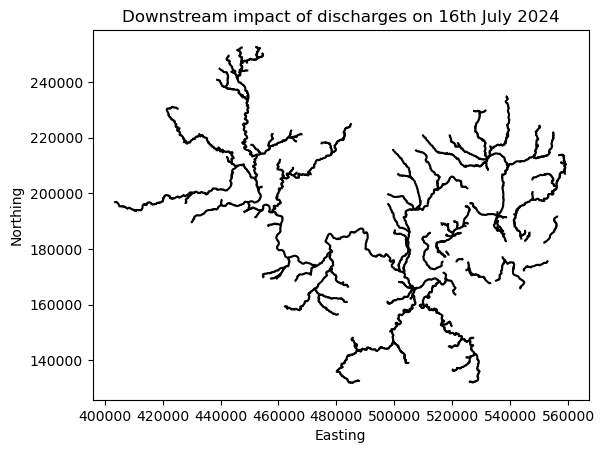

In [14]:
time = datetime.datetime(2024, 7, 16) # 16th July 2024
downstream = tw.get_historical_downstream_impact_at(time=time, include_recent_discharges=True) # Calculate downstream impact on 16th July, including recent discharges (within 48 hours)

# `downstream` is a 2D numpy array with the # number of discharges upstream of each cell on the DEM grid
# We can cast it to a geojson for easier visualisation

geojson = tw._accumulator.get_channel_segments(downstream, threshold=0.9)
segs = tw._accumulator.get_channel_segments(downstream, threshold=0.9)
for line in segs["coordinates"]:
    x = [c[0] for c in line]
    y = [c[1] for c in line]
    plt.plot(x, y, color="k")
plt.title("Downstream impact of discharges on 16th July 2024")
plt.xlabel("Easting"), plt.ylabel("Northing")

In fact, we can go further and calculate more detailed information about the downstream impact of CSOs at any point in the past. For example, we can calculate the total number of upstream discharges, and the number of upstream discharges per unit area, as well as the list of names of upstream discharges. This is done as follows: 

In [15]:
info_geojson = tw.get_historical_downstream_info_geojson_at(time=time, include_recent_discharges=True)

We can then visualise this: 

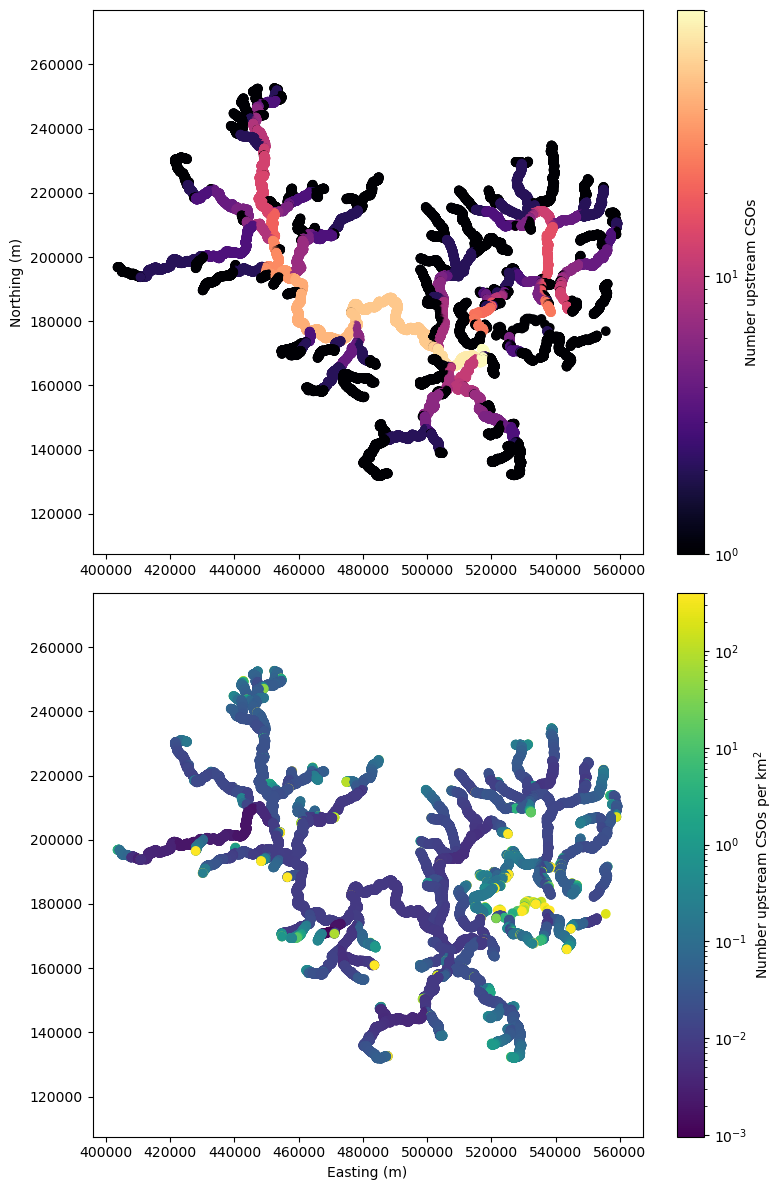

In [16]:
from matplotlib.colors import LogNorm

x, y, num_upst, num_upst_per_km2 = [], [], [], []
for feature in info_geojson.features:
    x.append(feature.geometry.coordinates[0])
    y.append(feature.geometry.coordinates[1])
    num_upst.append(feature.properties["number_upstream_CSOs"])
    num_upst_per_km2.append(feature.properties["number_CSOs_per_km2"])

plt.figure(figsize=(8, 12))
plt.subplot(2, 1, 1)
plt.scatter(x, y, c=num_upst, norm=LogNorm(), cmap="magma")
plt.ylabel("Northing (m)")
plt.axis("equal")
cb = plt.colorbar()
cb.set_label("Number upstream CSOs")
plt.subplot(2, 1, 2)
plt.scatter(x, y, c=num_upst_per_km2, norm=LogNorm(), cmap="viridis")
plt.axis("equal")
cb = plt.colorbar()
cb.set_label("Number upstream CSOs per km$^2$")
plt.xlabel("Easting (m)")
plt.tight_layout()
plt.show()

Lets say we want to look at how CSO overflows have changed over time. Or perhaps how many monitors are online at any one time across a water companies patch. We can do this using the `get_monitor_timeseries()` method of a `WaterCompany`. This generates time series of the number of active CSOs, recently active CSOs and online monitors at 15 minute intervals (the approximate frequency of the data). Lets generate this data from the start of 2022.

In [17]:
since = datetime.datetime(2022, 1, 1)
monitor_series = tw.get_monitor_timeseries(since=since)

Processing (Northern) Low Level No 1 Brook Green
Processing 15 Coldharbour Lane, Bushey
Processing Abbess Roding
Processing Abbey Mills
Processing Abbeydale Road
Processing Abingdon
Processing Acton & Storm Works
Processing Aldermaston
Processing Aldershot Town
Processing Alicia Avenue CSO
Processing Allendale Road
Processing Amersham Balancing Tanks/Amersham Vale STK
Processing Ampney St Peter
Processing Amyand Park Road, Twickenham
Processing Andoversford
Processing Appleton
Processing Arborfield
Processing Arford
Processing Ascot
Processing Ash Ridge (Wokingham)
Processing Ash Vale
Processing Aston Le Walls
Processing Auckland Road Storm Tanks
Processing Avon Dassett
Processing Avondale Rd
Processing Aylesbury
Processing Bakers Farm, High Wych
Processing Bampton
Processing Banbury
Processing Banbury Rd Middleton Cheney
Processing Bancroft Rugby Ground, Buckhurst Hill
Processing Barbers Lane
Processing Barkway
Processing Basingstoke
Processing Beckley
Processing Beckton
Processing Be

Now lets plot the results.

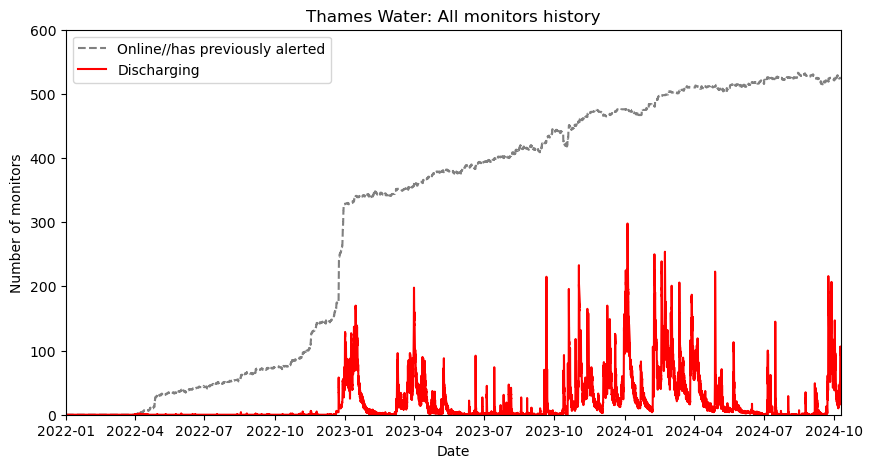

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(
    monitor_series["datetime"],
    monitor_series["number_online"],
    c="grey",
    label="Online//has previously alerted",
    linestyle="dashed",
)
plt.plot(
    monitor_series["datetime"],
    monitor_series["number_discharging"],
    c="red",
    label="Discharging",
)
plt.ylabel("Number of monitors")
plt.xlabel("Date")
# Set the xlimits to be the min and max of the datetime column
plt.xlim(monitor_series["datetime"].min(), monitor_series["datetime"].max())
plt.ylim(0, 600)
plt.title("Thames Water: All monitors history")
plt.legend()
plt.show()

Note that for "online" we conservatively assume that every monitor was _offline_ until we receive any positive event from it. This means that if a monitor is installed but recording    'NotDischarging' for a month until its first discharge event, it will be counted as offline for that month. Lacking any other information, this is the most conservative assumption we can make.  The first few monitors were attached to the API in April 2022, so the number of monitors "online" since then rises. But, in December '22/January '23 many more were hooked up and so the number of monitors "online" spikes. Since then, the coverage has got gradually better but the number of active monitors has remained fairly constant. It is therefore inappropriate to use this dataset to compare discharge histories between 2022 and 2023, as the number of active monitors has changed so much. You should use the annual returns for that instead. As expected there are more CSOs active during the winter months. To get a more averaged (less 'spiky') view of the data we can look at those which have been active in the last 48 hours (shown below) but the overall picture is the same.

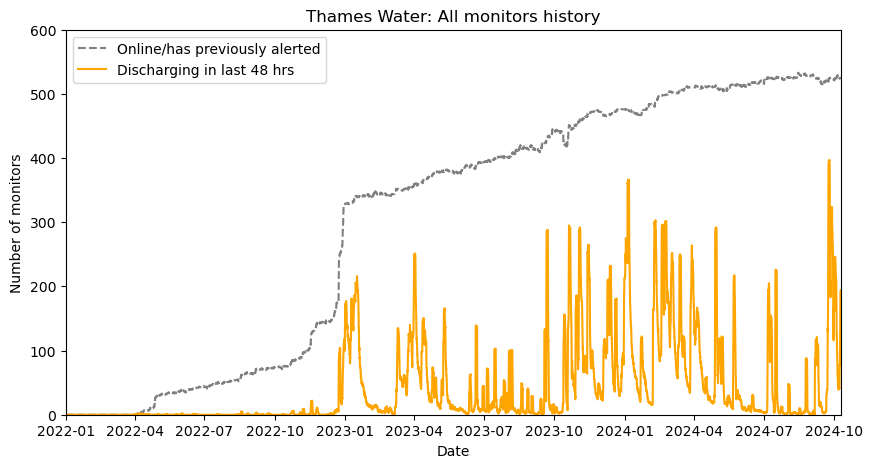

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(
    monitor_series["datetime"],
    monitor_series["number_online"],
    c="grey",
    label="Online/has previously alerted",
    linestyle="dashed",
)
plt.plot(
    monitor_series["datetime"],
    monitor_series["number_recently_discharging"],
    c="orange",
    label="Discharging in last 48 hrs",
)
plt.ylabel("Number of monitors")
plt.xlabel("Date")
# Set the xlimits to be the min and max of the datetime column
plt.xlim(monitor_series["datetime"].min(), monitor_series["datetime"].max())
plt.ylim(0, 600)
plt.title("Thames Water: All monitors history")
plt.legend()
plt.show()

Finally we can see how easy it is to generate some simple statistics about the data. For example:

In [20]:
number_online_now = monitor_series["number_online"].iloc[-1]
print(f"Number of monitors 'online' now: {number_online_now}")
number_discharging_now = monitor_series["number_discharging"].iloc[-1]
print(f"Number of monitors discharging now: {number_discharging_now}")
print(f"Proportion of monitors discharging now: {number_discharging_now / number_online_now * 100:.2f}%")
number_recently_discharging_now = monitor_series["number_recently_discharging"].iloc[-1]
print(f"Number of monitors discharging in last 48 hrs: {number_recently_discharging_now}")
print(f"Proportion of monitors discharging in last 48 hrs: {number_recently_discharging_now / number_online_now * 100:.2f}%")

Number of monitors 'online' now: 525
Number of monitors discharging now: 104
Proportion of monitors discharging now: 19.81%
Number of monitors discharging in last 48 hrs: 194
Proportion of monitors discharging in last 48 hrs: 36.95%
